# How to create a HDF5 Dataset
Hey guys! As already mentioned in the discussions <br>
( https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/discussion/409401 )<br>
, **HDF5** ist a great data format to manage such huge datasets and achieve fast read access.

That's why I wrote some code to convert the dataset to HDF5. As I couldn't find a way to upload datasets of this size (300+GB) on kaggle, this notebook only processes the first 2500 instances as an example. I'm currently working on finding a nice way to share the full HDF5-file.
<br><br>
I also want to mention that this is V1, which means **it is only a prototype**. I'm not an HDF5 expert myself, and I will constantly improve this version. So if you have any advice, **feel free to help!!!**
Some things I want to implement soon are for example parallel processing, fundamental preprocessing, and a better dataloader. 
<br><br>
To demonstrate the perfomance speedup, I used this Pytorch dataloader: <br>
https://www.kaggle.com/code/thomasrochefort/pytorch-dataloader-example
<br>So **check out this notebook** for more details about this part!!


### Versions: 
V1: <br>- 2x faster with num_workers = 1 <br>
    - Problems with num_workers = 4, almost no speedup <br>
    (Probably the bottleneck is opening the hdf5-file) <br>
    
V2: <br>- Now dtype float16 is used since we don't lose much information, as mentioned in discussions <br>
    - hdf5-file isn't opened in the get_item method but in the constructor. <br>
    - Much faster with num_workers = 1 <br>
    - 1.5x faster with num_workers = 4

In [2]:
%pip install h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 5.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Imports
import numpy as np
import pandas as pd
from glob import glob
import os
import json
import h5py
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
BASE_DIR = "/kaggle/working/dataset_train/ash_color/"
HDF_FILE = "/kaggle/working/dataset_train/hdf5/ash_color.hdf5"

In [4]:
def saveToHDF5(npy_path, group):
    npy_fname = npy_path.split(".")[0].split("/")[-1]
    array = np.load(npy_path)
    group.create_dataset(npy_fname, data=array)


with h5py.File(HDF_FILE, "w") as f:
    train = f.create_group("train")
    for npy_path in tqdm(glob(f"{BASE_DIR}/*.npy")):
        saveToHDF5(npy_path, f)

100%|██████████| 22385/22385 [02:07<00:00, 175.16it/s]


In [6]:
f = h5py.File(HDF_FILE, "r")
def PrintOnlyDataset(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name)

In [7]:
list(f.keys())[0]

'1000216489776414077'

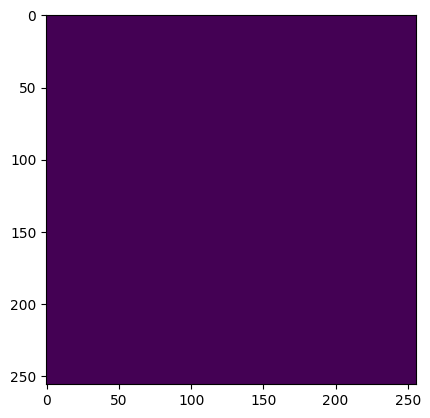

In [8]:
import matplotlib.pyplot as plt
# f['1000216489776414077'][:,:,:3].shape
plt.imshow(f['1000216489776414077'][:,:,3])

## Now let's compare the speedup!<br>
As mentioned earlier, I'm comparing the speedup by iterating over a dataloader once. I used this dataloader:<br>
https://www.kaggle.com/code/thomasrochefort/pytorch-dataloader-example 
<br>
For the HDF5-Dataloader, I had to make some small adjustments.

### 1) No HDF5

In [36]:
class ContrailDataset(Dataset):
    def __init__(self, base_dir, data_type='train', transform=None):
        assert data_type in ['train', 'validation', 'test'], \
            "'data_type' should be one of 'train', 'validation', or 'test'"

        self.base_dir = base_dir
        self.data_type = data_type
        self.transform = transform
        self.record = os.listdir(self.base_dir +'/'+ self.data_type)

    def __len__(self):
        return len(self.record)

    def __getitem__(self, idx):
        record_id = self.record[idx]
        record_dir = os.path.join(self.base_dir, self.data_type, record_id)

        bands_data = []
        for i in range(8, 17):
            band_file = os.path.join(record_dir, f'band_{str(i).zfill(2)}.npy')
            band_data = np.load(band_file)
            bands_data.append(band_data)
        bands_data = np.stack(bands_data, axis=-1)

        if self.data_type in ['train', 'validation']:
            pixel_masks_file = os.path.join(record_dir, 'human_pixel_masks.npy')
            pixel_masks = np.load(pixel_masks_file)
        else:
            pixel_masks = None
        return bands_data, pixel_masks


def get_dataloader(base_dir, data_type, batch_size, transform=None):
    dataset = ContrailDataset(base_dir, data_type=data_type, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers = 4)
    return dataloader

In [37]:
train_dataloader = get_dataloader(BASE_DIR, 'train', batch_size=16)

In [38]:
for bands, masks in tqdm(train_dataloader):
    continue

 17%|█▋        | 212/1284 [02:01<10:13,  1.75it/s]


KeyboardInterrupt: 

### 2) With HDF5

In [7]:
class ContrailDatasetHDF5(Dataset):
    def __init__(self, hdf5_file, transform=None):
        self.hdf5_file = hdf5_file
        self.transform = transform
        self.h5py = h5py.File(hdf5_file, "r")
        self.records = list(self.h5py.keys())[:2000]

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        record_id = self.records[idx]

        bands = self.h5py[record_id][:, :, :3]
        pixel_masks = self.h5py[record_id][:, :, 3]
        pixel_masks = np.expand_dims(pixel_masks, 2)
        return bands, pixel_masks


def get_dataloader_hdf5(path, batch_size, transform=None):
    dataset = ContrailDatasetHDF5(path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=1)
    return dataloader

In [8]:
path = HDF_FILE
train_dataloader_hdf5 = get_dataloader_hdf5(path, batch_size=1)
for bands, masks in tqdm(train_dataloader_hdf5):
    print(bands.shape)
    print(masks.shape)
    # print(np.transpose(bands[0],(1,2,0)).shape)
    # plt.imshow(np.transpose(bands[0],(1,2,0)))
    # plt.imshow(np.transpose(masks,(1,2,0)))
    break
        # break

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([1, 256, 256, 3])
torch.Size([1, 256, 256, 1])


In [12]:
ContrailDatasetHDF5(path)[0][0].shape

(256, 256, 3)

In [11]:
path = HDF_DIR + "/Google_Contrails.hdf5"
train_dataloader_hdf5 = get_dataloader_hdf5(path, 'train', batch_size=1)
for bands, masks in tqdm(train_dataloader_hdf5):
    continue
        # break

100%|██████████| 2000/2000 [00:44<00:00, 44.94it/s]


### Results
As you can see, the speedup is by a factor of 1.5. I'm confident we can do much better, and there are many things to improve. But the HDF5 file isn't just faster in reading. We can do our preprocessing to save even more time, and the bands are now already concatenated
<br><br>
It would be great if somebody could tell me if there is a way to upload the full HDF5-file (300+GB) to kaggle. Otherwise, I will share a link to my Google Drive. <br><br><br>
PS: If you want to save the dataset folder of this notebook, use: <br>
!kaggle datasets create -p "/kaggle/dataset_train/hdf5/" --dir-mode zip